# Setup

In [1]:
#GPU runtime required, should give CUDA version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import builtins
import os
import sys
import time
import argparse
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets, models

from PIL import Image, ImageFilter

import pandas as pd
import numpy as np
import math
import re
from scipy import stats

import shutil
import warnings
from torch.utils.data import DataLoader
import torch.nn.functional as F

from collections import Counter, OrderedDict
from random import shuffle

In [4]:
root_path = 'gdrive/MyDrive/Explainable_Wound_Classification/'

# Supervised CMSF

### Misc Functions

In [ ]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = False

In [ ]:
def get_mlp(inp_dim, hidden_dim, out_dim):
    mlp = nn.Sequential(
        nn.Linear(inp_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, out_dim),
    )
    return mlp

In [ ]:
def get_shuffle_ids(bsz):
    """generate shuffle ids for ShuffleBN"""
    forward_inds = torch.randperm(bsz).long().cuda()
    backward_inds = torch.zeros(bsz).long().cuda()
    value = torch.arange(bsz).long().cuda()
    backward_inds.index_copy_(0, forward_inds, value)
    return forward_inds, backward_inds

In [ ]:
def adjust_learning_rate(epoch, optimizer, cos, learning_rate, epochs, lr_decay_epochs, lr_decay_rate):
    if cos:
        # NOTE: since epoch starts with 1, we have to subtract 1
        new_lr = learning_rate * 0.5 * (1. + math.cos(math.pi * (epoch-1) / epochs))
        print('LR: {}'.format(new_lr))
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
    else:
        steps = np.sum(epoch >= np.asarray(lr_decay_epochs))
        if steps > 0:
            new_lr = learning_rate * (lr_decay_rate ** steps)
            print('LR: {}'.format(new_lr))
            for param_group in optimizer.param_groups:
                param_group['lr'] = new_lr

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### Transforms/Data Loading

In [ ]:
class Image_Dataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, label_fn, transform=None):
        """
        Image dataset. Returns tensorized images and labels with index
        Args:
            root_dir: path to a cropped mouse image dataset.
            label_fn: function that returns the correct label given an image name
        """
        self.root_dir = root_dir
        self.label_fn = label_fn
        self.transform = transform

        samples = []
        targets = []
        for f in os.listdir(root_dir):
            samples.append(os.path.join(root_dir, f))
            targets.append(label_fn(f))
        
        self.samples = samples
        self.targets = targets

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
            """
            Returns index, tensor data, and tensorized label.
            """
            img = self.pil_loader(self.samples[index])
            target = self.targets[index]

            if self.transform:
                img = self.transform(img)

            return index, img, torch.tensor(target)

    def __len__(self):
        return len(self.samples)

    def __str__(self):
        return "Image_Dataset:\n" + "Found " + str(len(self)) + " images in " + self.root_dir + "\n"

In [ ]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and target."""
    def __init__(self, weak_transform, strong_transform):
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        print(self.weak_transform)
        print(self.strong_transform)

    def __call__(self, x):
        q = self.strong_transform(x)
        t = self.weak_transform(x)
        return [q, t]

In [ ]:
# Create train loader
def get_train_loader(datapath, label_fn, batch_size, num_workers, weak_strong=True):
    traindir = os.path.join(datapath, 'train')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)

    augmentation_strong = [
        #transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.Resize(224),
        #transforms.RandomApply([
        #    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        #], p=0.8),
        #transforms.RandomGrayscale(p=0.2),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(saturation=(0,1)),
        transforms.RandomRotation((0, 360)),
        #transforms.RandomAffine((0,0), translate=(0.3, 0.3)),
        transforms.ToTensor(),
        normalize
    ]

    augmentation_weak = [
        #transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((0, 360)),
        transforms.ToTensor(),
        normalize,
    ]

    if weak_strong:
        train_dataset = Image_Dataset(
            traindir, label_fn, 
            TwoCropsTransform(transforms.Compose(augmentation_weak), transforms.Compose(augmentation_strong))
        )
    else:
        train_dataset = Image_Dataset(
            traindir, label_fn, 
            TwoCropsTransform(transforms.Compose(augmentation_strong), transforms.Compose(augmentation_strong))
        )

    print('==> train dataset')
    print(train_dataset)

    # NOTE: remove drop_last
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True)

    return train_loader

In [ ]:
def get_val_loader(datapath, label_fn, num_workers, batch_size=-1, test=False, train=False):
    if test:
        valdir = os.path.join(datapath, 'test')
    elif train:
        valdir = os.path.join(datapath, 'train')
    else:
        valdir = os.path.join(datapath, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    val_transform = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = Image_Dataset(valdir, label_fn, val_transform)

    if batch_size == -1:
        batch_size = len(dataset)

    val_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True,
    )
    return val_loader, dataset.samples

### Model Architecture

In [ ]:
def initialize_encoder(model_name, output_dim, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, output_dim)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
class MeanShift(nn.Module):
    def __init__(self, arch, m=0.99, mem_bank_size=128000, topk=5, output_dim=16):
        super(MeanShift, self).__init__()

        # save parameters
        self.m = m
        self.mem_bank_size = mem_bank_size
        self.topk = topk

        # create encoders and projection layers
        # both encoders should have same arch
        if 'resnet' in arch:
            self.encoder_q = initialize_encoder(arch, output_dim)[0]
            self.encoder_t = initialize_encoder(arch, output_dim)[0]

        # prediction layer
        self.predict_q = get_mlp(output_dim, output_dim * 2, output_dim)

        # copy query encoder weights to target encoder
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data.copy_(param_q.data)
            param_t.requires_grad = False

        print("using mem-bank size {}".format(self.mem_bank_size))
        # setup queue (For Storing Random Targets)
        self.register_buffer('queue', torch.randn(self.mem_bank_size, output_dim))
        # normalize the queue embeddings
        self.queue = nn.functional.normalize(self.queue, dim=1)
        # initialize the labels queue (For Purity measurement)
        self.register_buffer('labels', -1*torch.ones(self.mem_bank_size).long())
        # setup the queue pointer
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_target_encoder(self):
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data = param_t.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def data_parallel(self):
        self.encoder_q = torch.nn.DataParallel(self.encoder_q)
        self.encoder_t = torch.nn.DataParallel(self.encoder_t)
        self.predict_q = torch.nn.DataParallel(self.predict_q)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, targets, labels):
        batch_size = targets.shape[0]

        ptr = int(self.queue_ptr)
        assert self.mem_bank_size % batch_size == 0 

        # replace the targets at ptr (dequeue and enqueue)
        self.queue[ptr:ptr + batch_size] = targets
        self.labels[ptr:ptr + batch_size] = labels
        ptr = (ptr + batch_size) % self.mem_bank_size  # move pointer

        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_t, labels):
        # compute query features
        feat_q = self.encoder_q(im_q)
        # compute predictions for instance level regression loss
        query = self.predict_q(feat_q)
        query = nn.functional.normalize(query, dim=1)

        # compute target features
        with torch.no_grad():
            # update the target encoder
            self._momentum_update_target_encoder()

            # shuffle targets
            shuffle_ids, reverse_ids = get_shuffle_ids(im_t.shape[0])
            im_t = im_t[shuffle_ids]

            # forward through the target encoder
            current_target = self.encoder_t(im_t)
            current_target = nn.functional.normalize(current_target, dim=1)

            # undo shuffle
            current_target = current_target[reverse_ids].detach()
            self._dequeue_and_enqueue(current_target, labels)

        Q = query
        K = current_target
        M = self.queue.clone().detach()

        Lx = labels
        Lm = self.labels.clone().detach()

        b = Q.shape[0]
        m = M.shape[0]
        k = self.topk

        # 1. reshape labels to have same size
        Lx1 = Lx.unsqueeze(1).expand((b, m))
        Lm1 = Lm.unsqueeze(0).expand((b, m))
        Msk = Lx1 != Lm1

        # 2. calculate distances
        Dk = 2 - 2 * (K @ M.T)
        Dq = 2 - 2 * (Q @ M.T)

        # 3. set non category distances to 5 (max distance)
        Dk[torch.where(Msk)] = 5.0

        # 4. select indices of topk distances from Dk
        _, iNDk = Dk.topk(k, dim=1, largest=False)

        # 5. using above indices, gather the distances from Dq
        NDq = torch.gather(Dq, 1, iNDk)

        # 6. first, average over k, and then average over b
        L = NDq.mean(dim=1).mean()
        P = torch.gather(Lx1 == Lm1, 1, iNDk)
        purity = 100 * (torch.count_nonzero(P, dim=1) / k).mean()

        return L, purity

### Training Functions

In [ ]:
def train(epoch, train_loader, mean_shift, optimizer, print_freq):
    """
    one epoch training 
    """
    mean_shift.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    loss_meter = AverageMeter()
    purity_meter = AverageMeter()

    end = time.time()
    for idx, (indices, (im_q, im_t), labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        im_q = im_q.cuda(non_blocking=True)
        im_t = im_t.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        # ===================forward=====================
        loss, purity = mean_shift(im_q=im_q, im_t=im_t, labels=labels)

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        loss_meter.update(loss.item(), im_q.size(0))
        purity_meter.update(purity.item(), im_q.size(0))

        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t'
                  'purity {purity.val:.3f} ({purity.avg:.3f})\t'.format(
                   epoch, idx + 1, len(train_loader),
                   batch_time=batch_time,
                   data_time=data_time,
                   purity=purity_meter,
                   loss=loss_meter))
            sys.stdout.flush()
            sys.stdout.flush()

    return loss_meter.avg, purity_meter.avg

In [ ]:
def cmsf_main(data_path, checkpoint_path, label_fn, batch_size=16, num_workers=2, 
              epochs=200, print_freq=10, save_freq=10, weak_strong=True, 
              debug=False, arch='resnet', momentum=0.99, mem_bank_size=128000, 
              topk=5, learning_rate=0.05, sgd_momentum=0.9, weight_decay=1e-4, 
              weights=None, resume=None, restart=False, cos=True, lr_decay_rate=0.2, 
              lr_decay_epochs=[90,120], output_dim=16):
    opt = locals()
    del opt['label_fn']
    print(opt)

    if not resume and not weights:
        os.makedirs(checkpoint_path)

    train_loader = get_train_loader(data_path, label_fn, batch_size, num_workers, weak_strong)

    mean_shift = MeanShift(
        arch,
        m=momentum,
        mem_bank_size=mem_bank_size,
        topk=topk,
        output_dim=output_dim
    )
    mean_shift.data_parallel()
    mean_shift = mean_shift.cuda()
    print(mean_shift)

    print("Params to learn:")
    for name,param in mean_shift.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    params = [p for p in mean_shift.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params,
                                lr=learning_rate,
                                momentum=sgd_momentum,
                                weight_decay=weight_decay)

    cudnn.benchmark = True
    start_epoch = 1

    history_df = pd.DataFrame(index=range(start_epoch, epochs + 1))

    if weights:
        print('==> load weights from checkpoint: {}'.format(weights))
        ckpt = torch.load(weights)
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        if 'model' in ckpt:
            sd = ckpt['model']
        else:
            sd = ckpt['state_dict']
        msg = mean_shift.load_state_dict(sd, strict=False)
        optimizer.load_state_dict(ckpt['optimizer'])
        start_epoch = ckpt['epoch'] + 1
        history_df = ckpt['history_df']
        print(msg)

    if resume:
        print('==> resume from checkpoint: {}'.format(resume))
        ckpt = torch.load(resume)
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        mean_shift.load_state_dict(ckpt['state_dict'], strict=True)
        if not restart:
            optimizer.load_state_dict(ckpt['optimizer'])
            start_epoch = ckpt['epoch'] + 1
            history_df = ckpt['history_df']

    # routine
    for epoch in range(start_epoch, epochs + 1):

        adjust_learning_rate(epoch=epoch,
                             optimizer=optimizer,
                             cos=cos,
                             learning_rate=learning_rate,
                             epochs=epochs,
                             lr_decay_epochs=lr_decay_epochs,
                             lr_decay_rate=lr_decay_rate)
        print("==> training...")

        time1 = time.time()
        loss, purity = train(epoch, train_loader, mean_shift, optimizer, print_freq)

        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        history_df.loc[epoch, 'loss'] = loss
        history_df.loc[epoch, 'purity'] = purity

        # saving the model
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'opt': opt,
                'state_dict': mean_shift.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'history_df': history_df
            }

            save_file = os.path.join(checkpoint_path, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

            # help release GPU memory
            del state
            torch.cuda.empty_cache()

### Getting Label Assignments

In [ ]:
labels_df = pd.read_csv(root_path + 'Updated_Cropped_Images_Wound_Stage_Probabilities.csv', index_col='Image')
labels_df.head()

,hemostasis,inflammatory,proliferative,maturation
Image,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000


In [ ]:
labels_df['label'] = labels_df.index.map(lambda x: labels_df.loc[x].argmax())
labels_df.head()

,hemostasis,inflammatory,proliferative,maturation,label
Image,,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818,2
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000,1
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091,3
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455,3
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000,1


In [ ]:
labels_map = labels_df['label']
labels_map.head()

Image
Day 8_A8-4-L.png     2
Day 4_A8-3-R.png     1
Day 14_Y8-4-L.png    3
Day 7_Y8-4-L.png     3
Day 2_A8-1-L.png     1
Name: label, dtype: int64

### Folder to store outputs and number of epochs to run

In [ ]:
train_folder_name = 'supervised/3_simple_transforms/'
epochs = 200

# Supervised CMSF Training

### Training

In [ ]:
cmsf_main(
    data_path=root_path + 'Split_images', 
    checkpoint_path=root_path + 'outputs/' + train_folder_name, 
    label_fn=lambda x: labels_map[x],
    batch_size=8,
    num_workers=2,
    epochs=epochs,
    arch='resnet',
    topk=5,
    learning_rate=0.05,
    cos=True,
    mem_bank_size=128000,
    weak_strong=True,
    output_dim=16,
    debug=False)

{'data_path': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'checkpoint_path': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/supervised/3_simple_transforms/', 'batch_size': 8, 'num_workers': 2, 'epochs': 200, 'print_freq': 10, 'save_freq': 10, 'weak_strong': True, 'debug': False, 'arch': 'resnet', 'momentum': 0.99, 'mem_bank_size': 128000, 'topk': 5, 'learning_rate': 0.05, 'sgd_momentum': 0.9, 'weight_decay': 0.0001, 'weights': None, 'resume': None, 'restart': False, 'cos': True, 'lr_decay_rate': 0.2, 'lr_decay_epochs': [90, 120], 'output_dim': 16}
Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    Random

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

using mem-bank size 128000
MeanShift(
  (encoder_q): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bia

### Graphs

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + str(epochs) + '.pth')
history_df = cpkt['history_df']

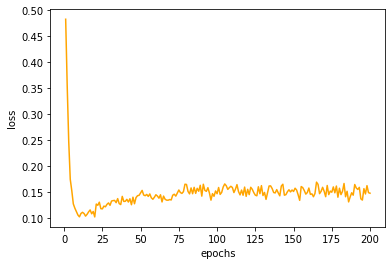

In [ ]:
_ = history_df['loss'].plot.line(xlabel='epochs', ylabel='loss', color='orange')

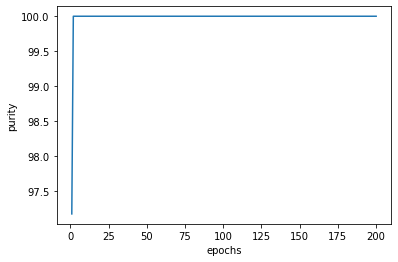

In [ ]:
_ = history_df['purity'].plot.line(xlabel='epochs', ylabel='purity')

# Linear Evaluation

### Misc Setup

In [ ]:
def save_checkpoint(state, is_best, save_dir):
    ckpt_path = os.path.join(save_dir, 'checkpoint.pth.tar')
    torch.save(state, ckpt_path)
    if is_best:
        best_ckpt_path = os.path.join(save_dir, 'model_best.pth.tar')
        shutil.copyfile(ckpt_path, best_ckpt_path)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

In [ ]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        return '\t'.join(entries)

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        # pdb.set_trace()
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

### Load Model

In [ ]:
def load_weights(model, wts_path, output_dim):
    wts = torch.load(wts_path)
    # pdb.set_trace()
    if 'state_dict' in wts:
        ckpt = wts['state_dict']
    elif 'model' in wts:
        ckpt = wts['model']
    else:
        ckpt = wts

    ckpt = {k.replace('module.', ''): v for k, v in ckpt.items()}
    ckpt = {k: v for k, v in ckpt.items() if 'encoder_t' not in k}
    ckpt = {k.replace('encoder_q.', ''): v for k, v in ckpt.items()}
    state_dict = {}

    for m_key, m_val in model.state_dict().items():
        if m_key in ckpt:
            state_dict[m_key] = ckpt[m_key]
        else:
            state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    model.load_state_dict(state_dict)

    predict_q_ckpt = {k: v for k, v in ckpt.items() if 'predict_q' in k}
    predict_q_ckpt = {k.replace('predict_q.', ''): v for k, v in predict_q_ckpt.items()}
    predict_q_model = get_mlp(output_dim, output_dim * 2, output_dim)

    predict_q_state_dict = {}

    for m_key, m_val in predict_q_model.state_dict().items():
        if m_key in predict_q_ckpt:
            predict_q_state_dict[m_key] = predict_q_ckpt[m_key]
        else:
            predict_q_state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    predict_q_model.load_state_dict(predict_q_state_dict)

    model.fc = nn.Sequential(model.fc, predict_q_model)

In [ ]:
def get_model(arch, output_dim, wts_path):
    model, _ = initialize_encoder(arch, output_dim)
    load_weights(model, wts_path, output_dim)

    for p in model.parameters():
        p.requires_grad = False

    return model

In [ ]:
class Normalize(nn.Module):
    def forward(self, x):
        return x / x.norm(2, dim=1, keepdim=True)


class FullBatchNorm(nn.Module):
    def __init__(self, var, mean):
        super(FullBatchNorm, self).__init__()
        self.register_buffer('inv_std', (1.0 / torch.sqrt(var + 1e-5)))
        self.register_buffer('mean', mean)

    def forward(self, x):
        return (x - self.mean) * self.inv_std

In [ ]:
def normalize(x):
    return x / x.norm(2, dim=1, keepdim=True)

In [ ]:
def get_feats(loader, model, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, ptr = None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (indices, images, target) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = normalize(model(images)).cpu()
            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets.argmax(axis=1))
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels

### Training Functions

In [ ]:
def train(train_loader, backbone, linear, optimizer, epoch, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top2 = AverageMeter('Acc@2', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top2],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    backbone.eval()
    linear.train()

    end = time.time()
    for i, (indices, images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        with torch.no_grad():
            output = backbone(images)
        output = linear(output)
        loss = F.cross_entropy(output, target)

        # measure accuracy and record loss
        acc1, acc2 = accuracy(output, target.argmax(axis=1), topk=(1, 2))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top2.update(acc2[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print(progress.display(i))

    return losses.avg, top1.avg.item(), top2.avg.item()

In [ ]:
def validate(val_loader, backbone, linear, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top2 = AverageMeter('Acc@2', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top2],
        prefix='Test: ')

    backbone.eval()
    linear.eval()

    with torch.no_grad():
        end = time.time()
        for i, (indices, images, target) in enumerate(val_loader):
            images = images.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = backbone(images)
            output = linear(output)
            loss = F.cross_entropy(output, target)

            # measure accuracy and record loss
            
            acc1, acc2 = accuracy(output, target.argmax(axis=1), topk=(1, 2))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top2.update(acc2[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@2 {top2.avg:.3f}'
              .format(top1=top1, top2=top2))

    return losses.avg, top1.avg.item(), top2.avg.item()

In [ ]:
def main_worker(data, label_fn, weights, save, logger=None, batch_size=16, workers=2, 
                epochs=40, arch='resnet50', print_freq=10, mlp=True, lr=0.01, 
                momentum=0.9, weight_decay=1e-4, lr_schedule='15,30,40', 
                resume=None, evaluate=False, n_classes=4, output_dim=16):
    best_acc1 = 0
    best_loss = np.inf

    # Data loading code
    traindir = os.path.join(data, 'train')
    valdir = os.path.join(data, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomRotation((0, 360)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = Image_Dataset(traindir, label_fn, train_transform)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True,
    )

    val_loader = torch.utils.data.DataLoader(
        Image_Dataset(valdir, label_fn, val_transform),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True,
    )

    train_val_loader = torch.utils.data.DataLoader(
        Image_Dataset(traindir, label_fn, val_transform),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True,
    )

    backbone = get_model(arch, output_dim, weights)
    backbone = nn.DataParallel(backbone).cuda()
    backbone.eval()


    cached_feats = '%s/var_mean.pth.tar' % save
    if not os.path.exists(cached_feats):
        train_feats, _ = get_feats(train_val_loader, backbone, print_freq, logger)
        train_var, train_mean = torch.var_mean(train_feats, dim=0)
        torch.save((train_var, train_mean), cached_feats)
    else:
        train_var, train_mean = torch.load(cached_feats)
    if mlp:
        c = output_dim
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(output_dim, c),
            nn.BatchNorm1d(c),
            nn.ReLU(inplace=True),
            nn.Linear(c, c),
            nn.BatchNorm1d(c),
            nn.ReLU(inplace=True),
            nn.Linear(c, n_classes),
        )
    else:
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(output_dim, n_classes)
        )

    print(backbone)
    print(linear)

    linear = linear.cuda()

    optimizer = torch.optim.SGD(linear.parameters(),
                                lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

    sched = [int(x) for x in lr_schedule.split(',')]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=sched
    )

    start_epoch = 0
    history_df = pd.DataFrame(index=range(start_epoch + 1, epochs + 1))

    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            linear.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            history_df = checkpoint['history_df']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    cudnn.benchmark = True

    if evaluate:
        validate(val_loader, backbone, linear, print_freq, logger)
        return

    for epoch in range(start_epoch, epochs):
        # train for one epoch
        loss, acc1, acc2 = train(
            train_loader, backbone, linear, optimizer, epoch, print_freq, logger)

        # evaluate on validation set
        val_loss, val_acc1, val_acc2 = validate(
            val_loader, backbone, linear, print_freq, logger)
        
        history_df.loc[epoch + 1, 'train_loss'] = loss
        history_df.loc[epoch + 1, 'train_acc1'] = acc1
        history_df.loc[epoch + 1, 'train_acc2'] = acc2
        history_df.loc[epoch + 1, 'val_loss'] = val_loss
        history_df.loc[epoch + 1, 'val_acc1'] = val_acc1
        history_df.loc[epoch + 1, 'val_acc2'] = val_acc2

        # modify lr
        lr_scheduler.step()
        # logger.info('LR: {:f}'.format(lr_scheduler.get_last_lr()[-1]))

        # remember best acc@1 and save checkpoint
        #is_best = val_acc1 > best_acc1
        is_best = val_loss < best_loss
        if is_best:
            best_loss = val_loss


        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': linear.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'backbone': backbone,
            'linear': linear,
            'history_df': history_df
        }, is_best, save)

In [ ]:
def main_linear_eval(data, label_fn, weights, save, batch_size=16, workers=2, 
                     epochs=40, arch='resnet50', print_freq=10, mlp=True, lr=0.01, 
                     momentum=0.9, weight_decay=1e-4, lr_schedule='15,30,40', 
                     resume=None, evaluate=False, seed=None, n_classes=4, output_dim=16):
    args = locals()
    del args['label_fn']

    if not resume:
        os.makedirs(save)
    print(args)

    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    main_worker(data=data, label_fn=label_fn, weights=weights, save=save, 
                batch_size=batch_size, workers=workers, 
                epochs=epochs, arch=arch, print_freq=print_freq, mlp=mlp, 
                lr=lr, momentum=momentum, weight_decay=weight_decay, 
                lr_schedule=lr_schedule, resume=resume, evaluate=evaluate, 
                n_classes=n_classes, output_dim=output_dim)

### Getting Labels

In [ ]:
labels_df = pd.read_csv(root_path + 'Updated_Cropped_Images_Wound_Stage_Probabilities.csv', index_col='Image')
labels_df.head()

,hemostasis,inflammatory,proliferative,maturation
Image,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000


In [ ]:
labels_df.loc['Day 8_A8-4-L.png'].to_numpy()

array([0.18181818, 0.09090909, 0.54545455, 0.18181818])

### Epoch number of CMSF to evaluate

In [ ]:
epoch = '20'
eval_suffix = '_2_deep_mlp'

# Linear Evaluation Training

### Training

In [ ]:
main_linear_eval(
    data=root_path + 'Split_images', 
    label_fn=lambda x: labels_df.loc[x].to_numpy(), 
    weights=root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + epoch + '.pth',
    save=root_path + 'outputs/' + train_folder_name + 'eval' + eval_suffix + epoch + '/', 
    batch_size=8, 
    workers=2, 
    epochs=40, 
    arch='resnet', 
    print_freq=10, 
    mlp=True, 
    lr=0.01,
    output_dim=16)

{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/supervised/3_simple_transforms/ckpt_epoch_20.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/supervised/3_simple_transforms/eval_2_deep_mlp20/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet', 'print_freq': 10, 'mlp': True, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}
Test: [ 0/24]	Time  0.217 ( 0.217)
Test: [10/24]	Time  0.042 ( 0.058)
Test: [20/24]	Time  0.050 ( 0.052)
DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=

### Graphs

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/checkpoint.pth.tar')
history_df = cpkt['history_df']
cpkt['epoch']

40

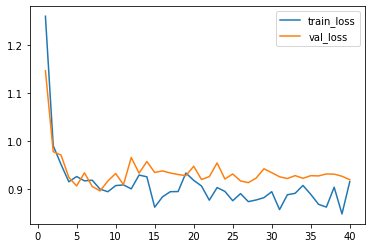

In [ ]:
_ = history_df[['train_loss', 'val_loss']].plot.line()

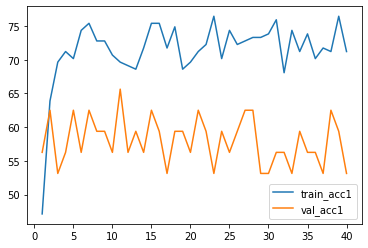

In [ ]:
_ = history_df[['train_acc1', 'val_acc1']].plot.line()

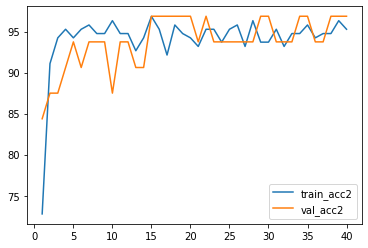

In [ ]:
_ = history_df[['train_acc2', 'val_acc2']].plot.line()

# Test Set

In [ ]:
test_loader, samples = get_val_loader(
    root_path + 'Split_images',
    lambda x: labels_df.loc[x].to_numpy(),
    2,
    test=True)

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/model_best.pth.tar')
backbone = cpkt['backbone']
linear = cpkt['linear']
best_epoch = cpkt['epoch']
print(cpkt['history_df']['val_acc1'][best_epoch])
print(best_epoch)

68.75
24


In [ ]:
cpkt['history_df']['val_loss']

1     1.119060
2     0.990543
3     0.958091
4     0.929985
5     0.922540
6     0.899248
7     0.949377
8     0.924173
9     0.895572
10    0.882376
11    0.899158
12    0.893341
13    0.883976
14    0.898357
15    0.914572
16    0.911248
17    0.905187
18    0.918914
19    0.932085
20    0.908347
21    0.915389
22    0.890200
23    0.894060
24    0.878044
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
36         NaN
37         NaN
38         NaN
39         NaN
40         NaN
Name: val_loss, dtype: float64

In [ ]:
backbone.eval()
linear.eval()

Sequential(
  (0): Normalize()
  (1): FullBatchNorm()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=16, out_features=16, bias=True)
  (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=16, out_features=4, bias=True)
)

In [ ]:
preds, names, labels = None, None, None

with torch.no_grad():
    for indices, images, labels in test_loader:
        preds = linear(backbone(images)).softmax(dim=1).cpu().numpy()
        names = np.array([x.split('/')[-1] for x in samples])
        labels = labels.numpy()

df = pd.DataFrame(index=names)
preds = [list(x) for x in preds]
labels = [list(x) for x in labels]
df['target'] = labels
df['pred'] = preds
df.head()

,target,pred
Day 14_Y8-4-L.png,"[0.0, 0.0, 0.0909090909090909, 0.909090909090909]","[0.0017747454, 0.011152404, 0.16575053, 0.8213..."
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.002328785, 0.032495562, 0.56392056, 0.4012551]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.47927228, 0.35087395, 0.15978402, 0.01006972]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.5012936, 0.41281945, 0.08132713, 0.0045598373]"
Day 12_A8-1-R.png,"[0.0, 0.2, 0.5, 0.3]","[0.21596289, 0.23239306, 0.34092495, 0.2107191]"


In [ ]:
props = df.index.map(lambda x: re.match('^Day (\d+)_(Y|A)8-(\d)-(L|R)', x).groups())
df['Day'] = props.map(lambda x: int(x[0]))
df['Age'] = props.map(lambda x: x[1])
df['Mouse'] = props.map(lambda x: int(x[2]))
df['Side'] = props.map(lambda x: x[3])
df['True, Pred'] = (df.index.map(lambda x: [np.argmax(df.loc[x]['target']), np.argmax(df.loc[x]['pred'])]))
df.head()

,target,pred,Day,Age,Mouse,Side,"True, Pred"
Day 14_Y8-4-L.png,"[0.0, 0.0, 0.0909090909090909, 0.909090909090909]","[0.0017747454, 0.011152404, 0.16575053, 0.8213...",14,Y,4,L,"[3, 3]"
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.002328785, 0.032495562, 0.56392056, 0.4012551]",7,Y,4,L,"[3, 2]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.47927228, 0.35087395, 0.15978402, 0.01006972]",9,A,1,R,"[1, 0]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.5012936, 0.41281945, 0.08132713, 0.0045598373]",4,A,1,R,"[1, 0]"
Day 12_A8-1-R.png,"[0.0, 0.2, 0.5, 0.3]","[0.21596289, 0.23239306, 0.34092495, 0.2107191]",12,A,1,R,"[2, 2]"


In [ ]:
young_df = df[df.Age == 'Y']
young_df.sort_values('Day')[['target', 'pred', 'True, Pred']]

,target,pred,"True, Pred"
Day 0_Y8-4-L.png,"[1.0, 0.0, 0.0, 0.0]","[0.75539887, 0.2034507, 0.03631298, 0.004837382]","[0, 0]"
Day 1_Y8-4-L.png,"[0.57, 0.43, 0.0, 0.0]","[0.40914467, 0.29518524, 0.19668949, 0.09898058]","[0, 0]"
Day 2_Y8-4-L.png,"[0.8, 0.2, 0.0, 0.0]","[0.528175, 0.4046887, 0.06309596, 0.00404038]","[0, 0]"
Day 3_Y8-4-L.png,"[0.2, 0.8, 0.0, 0.0]","[0.59552425, 0.32178634, 0.072050326, 0.01063907]","[1, 0]"
Day 4_Y8-4-L.png,"[0.4, 0.5, 0.1, 0.0]","[0.4328404, 0.43165168, 0.12760992, 0.007898065]","[1, 0]"
Day 5_Y8-4-L.png,"[0.3, 0.5, 0.2, 0.0]","[0.051499426, 0.27842832, 0.5608884, 0.10918383]","[1, 2]"
Day 6_Y8-4-L.png,"[0.1, 0.3, 0.6, 0.0]","[0.038040455, 0.2069212, 0.6579035, 0.09713488]","[2, 2]"
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.002328785, 0.032495562, 0.56392056, 0.4012551]","[3, 2]"
Day 8_Y8-4-L.png,"[0.0, 0.0, 0.6, 0.4]","[0.010329344, 0.059756774, 0.674866, 0.25504792]","[2, 2]"
Day 9_Y8-4-L.png,"[0.0, 0.0, 0.6, 0.4]","[0.0009558308, 0.016885534, 0.5106306, 0.47152...","[2, 2]"


In [ ]:
aged_df = df[df.Age == 'A']
aged_df.sort_values('Day')[['target', 'pred', 'True, Pred']]

,target,pred,"True, Pred"
Day 0_A8-1-R.png,"[0.9, 0.1, 0.0, 0.0]","[0.46024433, 0.4675919, 0.06694661, 0.0052171606]","[0, 1]"
Day 1_A8-1-R.png,"[0.1, 0.8, 0.1, 0.0]","[0.6090964, 0.2928627, 0.088091284, 0.009949591]","[1, 0]"
Day 2_A8-1-R.png,"[0.4, 0.5, 0.1, 0.0]","[0.47660112, 0.40228727, 0.113308065, 0.007803...","[1, 0]"
Day 3_A8-1-R.png,"[0.4, 0.5, 0.1, 0.0]","[0.5630596, 0.3522705, 0.079280734, 0.005389061]","[1, 0]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.5012936, 0.41281945, 0.08132713, 0.0045598373]","[1, 0]"
Day 5_A8-1-R.png,"[0.2, 0.5, 0.3, 0.0]","[0.06062132, 0.12682313, 0.23070836, 0.58184713]","[1, 3]"
Day 6_A8-1-R.png,"[0.2, 0.7, 0.1, 0.0]","[0.20632283, 0.40435195, 0.36771208, 0.021613203]","[1, 1]"
Day 7_A8-1-R.png,"[0.1, 0.7, 0.1, 0.1]","[0.1598706, 0.42457342, 0.38817704, 0.027378902]","[1, 1]"
Day 8_A8-1-R.png,"[0.2, 0.6, 0.2, 0.0]","[0.07660238, 0.3247049, 0.5637538, 0.03493896]","[1, 2]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.47927228, 0.35087395, 0.15978402, 0.01006972]","[1, 0]"


In [ ]:
test_acc = df['True, Pred'].map(lambda x: x[0] == x[1]).to_numpy().mean()
test_acc

0.5625

# Some Cluster Analysis

### Setup

In [ ]:
!pip install fuzzy-c-means
from fcmeans import FCM

     |████████████████████████████████| 10.9 MB 10.7 MB/s 


In [ ]:
def fuzzy_c_means(feats, nmb_clusters):
    feats = feats.numpy()
    
    fcm = FCM(n_clusters=nmb_clusters)
    fcm.fit(feats)

    return fcm.predict(feats), fcm

### Analysis

In [ ]:
data_path = root_path + 'Split_images'
weights_path = root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + epoch + '.pth'

encoder = get_model('resnet', 16, weights_path)
train_val_loader, train_samples = get_val_loader(data_path, lambda x: labels_df.loc[x].to_numpy(), 0, train=True)

In [ ]:
encoder.eval()

with torch.no_grad():
    for indices, images, labels in train_val_loader:
        embeddings = encoder(images)

        _, fcm = fuzzy_c_means(embeddings, 4)
        preds = fcm.soft_predict(embeddings.numpy())
        labels = labels.numpy()
        x = 4


In [ ]:
single_preds = preds.argmax(axis=1)
single_labels = labels.argmax(axis=1)

In [ ]:
pred_indices_0 = [i for (i, x) in enumerate(single_preds) if x == 0]
pred_indices_1 = [i for (i, x) in enumerate(single_preds) if x == 1]
pred_indices_2 = [i for (i, x) in enumerate(single_preds) if x == 2]
pred_indices_3 = [i for (i, x) in enumerate(single_preds) if x == 3]

In [ ]:
print(stats.mode(single_labels[pred_indices_0])[0][0])
print(stats.mode(single_labels[pred_indices_1])[0][0])
print(stats.mode(single_labels[pred_indices_2])[0][0])
print(stats.mode(single_labels[pred_indices_3])[0][0])

2
0
3
1


In [ ]:
single_labels[pred_indices_1]

array([2, 3, 2, 1, 3, 0, 2, 2, 0, 0, 2, 1, 0, 1, 2, 2, 0, 1, 1, 1, 1, 1,
       1, 2, 2, 0, 1, 0, 1, 2, 2, 1, 1, 0, 1, 2, 2, 2, 0, 1, 1])

In [ ]:
single_labels[pred_indices_2]

array([1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 2, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0])

In [ ]:
m = {2:0, 0:1, 3:2, 1:3}
preds = np.array([[p[m[0]], p[m[1]], p[m[2]], p[m[3]]] for p in preds])

In [ ]:
single_preds = preds.argmax(axis=1)

In [ ]:
acc = (single_preds == single_labels).mean()
acc

0.675392670157068

# KNN Evaluation

### Setup

In [ ]:
!pip install faiss-gpu
import faiss

### Misc Functions

In [ ]:
def l2_normalize(x):
    return x / x.norm(2, dim=1, keepdim=True)

In [ ]:
def log(string, file):
    print(string)
    file.write(string + '\n')

In [ ]:
def faiss_knn(feats_train, targets_train, feats_val, targets_val, k):
    feats_train = feats_train.numpy()
    targets_train = targets_train.numpy()
    feats_val = feats_val.numpy()
    targets_val = targets_val.numpy()

    d = feats_train.shape[-1]

    index = faiss.IndexFlatL2(d)  # build the index
    co = faiss.GpuMultipleClonerOptions()
    co.useFloat16 = True
    co.shard = True
    gpu_index = faiss.index_cpu_to_all_gpus(index, co)
    gpu_index.add(feats_train)

    D, I = gpu_index.search(feats_val, k)

    pred = np.zeros(I.shape[0], dtype=np.int)
    conf_mat = np.zeros((1000, 1000), dtype=np.int)
    for i in range(I.shape[0]):
        votes = list(Counter(targets_train[I[i]]).items())
        shuffle(votes)
        pred[i] = max(votes, key=lambda x: x[1])[0]
        conf_mat[targets_val[i], pred[i]] += 1

    acc = 100.0 * (pred == targets_val).mean()
    assert acc == (100.0 * (np.trace(conf_mat) / np.sum(conf_mat)))

    # per_cat_acc = 100.0 * (np.diag(conf_mat) / np.sum(conf_mat, axis=1))
    # sparse_cats = [58, 155, 356, 747, 865, 234, 268, 384, 385, 491, 498, 538, 646, 650, 726, 860, 887, 15, 170, 231]
    # s = ' '.join('{}'.format(c) for c in sparse_cats)
    # print('==> cats: {}'.format(s))
    # s = ' '.join('{:.1f}'.format(a) for a in per_cat_acc[sparse_cats])
    # print('==> acc/cat: {}'.format(s))
    # print('==> mean acc: {}'.format(per_cat_acc[sparse_cats].mean()))

    return acc

In [ ]:
def get_feats(loader, model, print_freq):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, indices, ptr = None, None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (index, images, target) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = model(images).cpu()
            cur_indices = index.cpu()

            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()
                indices = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets)
            indices.index_copy_(0, inds, cur_indices)
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels, indices

In [ ]:
def subset_classes(dataset, num_classes=10):
    np.random.seed(1234)
    all_classes = sorted(dataset.class_to_idx.items(), key=lambda x: x[1])
    subset_classes = [all_classes[i] for i in np.random.permutation(len(all_classes))[:num_classes]]
    subset_classes = sorted(subset_classes, key=lambda x: x[1])
    dataset.classes_to_idx = {c: i for i, (c, _) in enumerate(subset_classes)}
    dataset.classes = [c for c, _ in subset_classes]
    orig_to_new_inds = {orig_ind: new_ind for new_ind, (_, orig_ind) in enumerate(subset_classes)}
    dataset.samples = [(p, orig_to_new_inds[i]) for p, i in dataset.samples if i in orig_to_new_inds]

### Main Function

In [ ]:
def main_worker(arch, output_dim, data_path, wts_path, output_path, batch_size, 
                label_fn, num_workers=2, print_freq=10, k_s=range(1,21)):

    start = time.time()
    # Get train/val loader 
    # ---------------------------------------------------------------
    train_loader, _ = get_val_loader(data_path, label_fn, num_workers, batch_size, train=True)
    val_loader, _   = get_val_loader(data_path, label_fn, num_workers, batch_size)
    test_loader, _  = get_val_loader(data_path, label_fn, num_workers, batch_size, test=True)

    # Create and load the model
    # If you want to evaluate your model, modify this part and load your model
    # ------------------------------------------------------------------------
    # MODIFY 'get_model' TO EVALUATE YOUR MODEL
    model = get_model(arch, output_dim, wts_path).cuda()

    # ------------------------------------------------------------------------
    # Forward training samples throw the model and cache feats
    # ------------------------------------------------------------------------
    cudnn.benchmark = True

    train_feats, train_labels, train_inds = get_feats(train_loader, model, print_freq)

    val_feats, val_labels, val_inds = get_feats(val_loader, model, print_freq)

    test_feats, test_labels, test_inds = get_feats(test_loader, model, print_freq)

    # ------------------------------------------------------------------------
    # Calculate NN accuracy on validation set
    # ------------------------------------------------------------------------

    # train_feats = l2_normalize(train_feats)
    # val_feats = l2_normalize(val_feats)

    # mean = torch.mean(train_feats, dim=0)
    # std = torch.std(train_feats, dim=0)

    # stdmean = std.mean()
    # train_feats = train_feats / stdmean
    # val_feats = val_feats / stdmean

    # train_feats = train_feats / std
    # val_feats = val_feats / std

    # train_feats = (train_feats - mean) / std
    # val_feats = (val_feats - mean) / std

    # train_feats = train_feats - mean
    # val_feats = val_feats - mean

    # train_feats = train_feats / TEMP
    # val_feats = val_feats / TEMP

    train_feats = l2_normalize(train_feats)
    val_feats = l2_normalize(val_feats)
    test_feats = l2_normalize(test_feats)

    output = open(output_path, 'w')

    for k in k_s:
        log(f'k: {k}', output)
        val_acc  = faiss_knn(train_feats, train_labels, val_feats, val_labels, k)
        test_acc = faiss_knn(train_feats, train_labels, test_feats, test_labels, k)
        nn_time = time.time() - start
        log('=> time : {:.2f}s'.format(nn_time), output)
        log(' * Val_Acc {:.2f}'.format(val_acc), output)
        log(' * Test_Acc {:.2f}'.format(test_acc), output)

    output.close()

### Evaluation

In [ ]:
for epoch in range(10, 201, 10):
    print(f"Epoch: {epoch}")
    main_worker(arch='resnet', 
                output_dim=16, 
                data_path=root_path + 'Split_images', 
                wts_path=root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + str(epoch) + '.pth', 
                output_path=root_path + 'outputs/' + train_folder_name + 'eval' + eval_suffix + 'knn_' + str(epoch), 
                batch_size=8, 
                label_fn=lambda x: labels_map[x], 
                num_workers=2, 
                print_freq=10,
                k_s=[1])

Epoch: 10
Test: [ 0/24]	Time  0.259 ( 0.259)
Test: [10/24]	Time  0.044 ( 0.060)
Test: [20/24]	Time  0.039 ( 0.053)
Test: [0/4]	Time  0.251 ( 0.251)
Test: [0/4]	Time  0.232 ( 0.232)
k: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

=> time : 4.02s
 * Val_Acc 53.12
 * Test_Acc 50.00
Epoch: 20
Test: [ 0/24]	Time  0.434 ( 0.434)
Test: [10/24]	Time  0.091 ( 0.099)
Test: [20/24]	Time  0.049 ( 0.077)
Test: [0/4]	Time  0.448 ( 0.448)
Test: [0/4]	Time  0.439 ( 0.439)
k: 1
=> time : 5.98s
 * Val_Acc 56.25
 * Test_Acc 53.12
Epoch: 30
Test: [ 0/24]	Time  0.419 ( 0.419)
Test: [10/24]	Time  0.079 ( 0.091)
Test: [20/24]	Time  0.123 ( 0.076)
Test: [0/4]	Time  0.350 ( 0.350)
Test: [0/4]	Time  0.376 ( 0.376)
k: 1
=> time : 5.54s
 * Val_Acc 59.38
 * Test_Acc 53.12
Epoch: 40
Test: [ 0/24]	Time  0.409 ( 0.409)
Test: [10/24]	Time  0.066 ( 0.094)
Test: [20/24]	Time  0.033 ( 0.082)
Test: [0/4]	Time  0.378 ( 0.378)
Test: [0/4]	Time  0.420 ( 0.420)
k: 1
=> time : 5.94s
 * Val_Acc 75.00
 * Test_Acc 56.25
Epoch: 50
Test: [ 0/24]	Time  0.360 ( 0.360)
Test: [10/24]	Time  0.071 ( 0.093)
Test: [20/24]	Time  0.114 ( 0.081)
Test: [0/4]	Time  0.480 ( 0.480)
Test: [0/4]	Time  0.389 ( 0.389)
k: 1
=> time : 6.75s
 * Val_Acc 68.75
 * Test_Acc 59.38
E